In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv
/kaggle/input/chunked-training-data-for-predict-taxi-fares/df_train.csv


### Importing the graphical libraries and seeting the parameters

In [2]:
'''Customize visualization
Seaborn and matplotlib visualization.'''
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')                    
sns.set_style({'axes.grid':False}) 

'''Plotly visualization .'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected = True) # Required to use plotly offline in jupyter notebook

# 1. Reading the data

**As the data contains approximately 5M rows and due to limitation of the processor, the data has been divided into chunks and random rows based on sample fraction has been skipped using the function of _read.csv_ of pandas library.**

In [3]:
%%time

df_train_type = {
    'fare_amount':'float32',
    'pickup_datetime':'str',
    'pickup_longitude':'float32',
    'pickup_latitude':'float32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude': 'float32',
    'passenger_count': 'uint8'
}

chunksize=10**7
df_train_list=[]
batch_no=1
sample_frac = 0.30

selected_cols = 'fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count'.split(',')


def skip_row(row_idx):
    if row_idx == 0:
        return False
    return random.random() > sample_frac  ## 

for chunk in pd.read_csv('../input/new-york-city-taxi-fare-prediction/train.csv', dtype=df_train_type,
                         usecols=list(df_train_type), chunksize=chunksize, skiprows=skip_row):
    # converting pickup_datetime from string to datetime object
    chunk['pickup_datetime'] = pd.to_datetime(chunk['pickup_datetime'].str.slice(0,19), utc=True, format='%Y-%m-%d %H:%M:%S')
#     chunk.to_csv(str(batch_no))
    df_train_list.append(chunk)
    print(batch_no, "chunk appended")
    batch_no += 1

1 chunk appended
2 chunk appended
CPU times: user 1min 11s, sys: 6.74 s, total: 1min 17s
Wall time: 2min 20s


The dataframe of the training data has been created. 
> * The rows now have been reduced to 1.6M 

In [4]:
df_train = pd.concat(df_train_list)
del df_train_list
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16627031 entries, 0 to 16627030
Data columns (total 7 columns):
 #   Column             Dtype              
---  ------             -----              
 0   fare_amount        float32            
 1   pickup_datetime    datetime64[ns, UTC]
 2   pickup_longitude   float32            
 3   pickup_latitude    float32            
 4   dropoff_longitude  float32            
 5   dropoff_latitude   float32            
 6   passenger_count    uint8              
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 459.8 MB


#### Reading the submission and testing dataset

In [5]:
sub_df= pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv')
df_test= pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/test.csv')

df = df_train
df_original = df_train

# 2. Data Cleaning

#### Checking for the missing values in the data. If found, the respective rows will be deleted from the training set __to remove any trace of bias in the data.__ 

In [6]:
%%time
#  checking for null values in dataset 
df.isnull().sum()

CPU times: user 217 ms, sys: 21.2 ms, total: 238 ms
Wall time: 236 ms


fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    122
dropoff_latitude     122
passenger_count        0
dtype: int64

___ 111 rows in the data has missing values

In [7]:
%%time
df = df.dropna(how='any', axis='rows') # drop null values found at earlier stage 

CPU times: user 1.02 s, sys: 494 ms, total: 1.51 s
Wall time: 1.49 s


In [8]:
%%time
df.isnull().sum()

CPU times: user 208 ms, sys: 25.4 ms, total: 234 ms
Wall time: 231 ms


fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [9]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.662010e+07,1.662010e+07,1.662010e+07,1.662010e+07,1.662010e+07,1.662010e+07
mean,1.134404e+01,-7.251060e+01,3.991996e+01,-7.250957e+01,3.992126e+01,1.685423e+00
std,1.802217e+01,1.314975e+01,9.863177e+00,1.299580e+01,9.910726e+00,1.322416e+00
min,-3.000000e+02,-3.440697e+03,-3.488031e+03,-3.440697e+03,-3.475482e+03,0.000000e+00
25%,6.000000e+00,-7.399206e+01,4.073495e+01,-7.399140e+01,4.073405e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075266e+01,-7.398015e+01,4.075317e+01,1.000000e+00
75%,1.250000e+01,-7.396706e+01,4.076714e+01,-7.396367e+01,4.076811e+01,2.000000e+00
max,6.155086e+04,3.456223e+03,3.361266e+03,3.457622e+03,3.407392e+03,2.080000e+02


## 2.1 Removing Outliers
We'll use the following ranges:

* fare_amount: 1 to 500
* longitudes: -75 to -72
* latitudes: 40 to 42
* passenger_count: 1 to 6

### Finding anomalies in the training dataset

In [12]:
dtr1 = df[df['fare_amount']<0]
dtr1.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000
mean,-10.811470,-68.331480,37.643004,-67.845746,37.376664,1.929134
std,21.660373,19.626155,10.811860,20.381732,11.228477,1.480568
min,-300.000000,-74.086050,0.000000,-74.178280,0.000000,0.000000
25%,-7.000000,-73.990155,40.722194,-73.989486,40.719493,1.000000
50%,-4.000000,-73.976035,40.750526,-73.974160,40.750559,1.000000
75%,-2.500000,-73.947538,40.764031,-73.942394,40.764893,2.000000
max,-0.010000,0.000000,40.918526,0.000000,40.941280,6.000000


#### Fare amount > 500
In most of the cases where fare amountis negative, the following are the observation: 
* Pickup location is same as the drop loacation 
* either the pickup longitude/lattitude or dropoff longitude/lattitude is 0
* Maximum value of amount is infinity 
* only 10 rows are found to be > 500, definitely an outlier



In [13]:
dtr1 = df[df['fare_amount']>500]
dtr1.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,13.000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,5732.610,-45.549906,24.976299,-45.545722,24.973671,1.076923
std,16788.428,37.481002,20.555303,37.477565,20.553120,0.277350
min,544.440,-74.436810,0.000000,-74.436615,0.000000,1.000000
25%,563.040,-73.967710,0.000000,-73.945570,0.000000,1.000000
50%,900.000,-73.937780,40.664413,-73.935555,40.664413,1.000000
75%,1564.500,0.000000,40.758255,0.000000,40.750782,1.000000
max,61550.860,0.000000,40.850475,0.000000,40.859848,2.000000


In [14]:
str1 = str(len(df[df['fare_amount']<0]))
print('No of rows which has fare amount < 0 are: ', str1)
str2 = str(len(df[df['fare_amount']> 550]))
print('No of rows which has fare amount < 0 are: ', str2)
str3 = str(len(df[df['pickup_longitude'] == 0]))
print('No of rows which has fare amount < 0 are: ', str3)
str4 = str(len(df[df['pickup_latitude'] == 0]))
print('No of rows which has fare amount < 0 are: ', str4)
str5 = str(len(df[df['passenger_count'] >6]))
print('No of rows which has fare amount < 0 are: ', str5)

No of rows which has fare amount < 0 are:  762
No of rows which has fare amount < 0 are:  11
No of rows which has fare amount < 0 are:  316181
No of rows which has fare amount < 0 are:  315109
No of rows which has fare amount < 0 are:  37


In [15]:
def clean_data(train_df):
    
    print("Initial Train dataframe length: " + str(len(train_df)))
    
    # Remove null data
    train_df=train_df.dropna(how='any',axis='rows')
    print("Train dataframe length after removing NULL values: " + str(len(train_df)))
    
    train_df=train_df[(train_df.passenger_count<=6) & (train_df.passenger_count>=1)]
    print("Train dataframe length after filtering based on passenger counts: " + str(len(train_df)))
    
#     train_df=train_df[(train_df.fare_amount>0) | ((train_df.fare_amount==0) & (train_df.manhattan_dist<0.75))]
    train_df=train_df[(train_df.fare_amount <= train_df.fare_amount.mean()+10*train_df.fare_amount.std())]
    print("Train dataframe length after filtering based on fare amount: " + str(len(train_df)))
    
    train_df=train_df[(train_df.pickup_longitude>=min(df_test.pickup_longitude)) & (train_df.pickup_longitude<=max(df_test.pickup_longitude))]
    train_df=train_df[(train_df.pickup_latitude>=min(df_test.pickup_latitude)) & (train_df.pickup_latitude<=max(df_test.pickup_latitude))]    
    train_df=train_df[(train_df.dropoff_longitude>=min(df_test.dropoff_longitude)) & (train_df.dropoff_longitude<=max(df_test.dropoff_longitude))]
    train_df=train_df[(train_df.dropoff_latitude>=min(df_test.dropoff_latitude)) & (train_df.dropoff_latitude<=max(df_test.dropoff_latitude))]
    print("Train dataframe length after filtering based on test data coordinates boundary: " + str(len(train_df)))
    
    return train_df


In [16]:
%%time
def remove_outliers(df):
    return df[(df['fare_amount'] >= 1.) & 
              (df['fare_amount'] <= 500.) &
              (df['pickup_longitude'] >= -75) & 
              (df['pickup_longitude'] <= -72) & 
              (df['dropoff_longitude'] >= -75) & 
              (df['dropoff_longitude'] <= -72) & 
              (df['pickup_latitude'] >= 40) & 
              (df['pickup_latitude'] <= 42) & 
              (df['dropoff_latitude'] >=40) & 
              (df['dropoff_latitude'] <= 42) & 
              (df['passenger_count'] >= 1) & 
              (df['passenger_count'] <= 6)]

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.34 µs


In [17]:
df = clean_data(df)

Initial Train dataframe length: 16620102
Train dataframe length after removing NULL values: 16620102
Train dataframe length after filtering based on passenger counts: 16561672
Train dataframe length after filtering based on fare amount: 16561039
Train dataframe length after filtering based on test data coordinates boundary: 16206930


In [18]:
df = remove_outliers(df)

## 3. Performing **Feature Engineering** to understand the data accurately to derive the inferences. 

Observations: 
1. add a feature for distance between pickup place and drop place
2. Need to perform feature extraction for timeAdding few more features to dive deeper into it

In [19]:
%%time
# Add haversine, euclidean and manhatten distance (great circle distance between two points on earth given their longitude and lattitude)

import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 18.4 µs


In [20]:
def getEuclidean_distance(pickup_long, pickup_lat, dropoff_long, dropoff_lat):
    return np.sqrt(((pickup_long-dropoff_long)**2) + ((pickup_lat-dropoff_lat)**2))

def get_manhattan_dist(pickup_long, pickup_lat, dropoff_long, dropoff_lat):
    return ((dropoff_long - pickup_long).abs() + (dropoff_lat - pickup_lat).abs())


Extracting data parameters to know the effect individual weekday and particular hour of the day. 

In [21]:
def add_dateparts(df, col):
    df['year'] = df[col].dt.year
    df['month'] = df[col].dt.month
    df['day'] = df[col].dt.day
    df['weekday'] = df[col].dt.weekday
    df[col + '_hour'] = df[col].dt.hour

Adding the distances in the main training dataframe

In [22]:
%%time
df['haversine_distance'] = haversine_np(df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude'])

CPU times: user 2.94 s, sys: 754 ms, total: 3.7 s
Wall time: 1.89 s


In [23]:
%%time
# Add new column (manhattan_dist) to both training and test dataframe.
df['manhattan_dist'] = get_manhattan_dist(df.pickup_longitude, df.pickup_latitude,
                                              df.dropoff_longitude, df.dropoff_latitude).astype(np.float32)


CPU times: user 241 ms, sys: 220 ms, total: 461 ms
Wall time: 228 ms


In [24]:
df['euclidean_dist'] = getEuclidean_distance(df.pickup_longitude, df.pickup_latitude,
                                                   df.dropoff_longitude, df.dropoff_latitude).astype(np.float32)

In [25]:
%%time
add_dateparts(df, 'pickup_datetime')

CPU times: user 9.36 s, sys: 312 ms, total: 9.67 s
Wall time: 9.68 s


## 3.1 Corelation analysis

Compute the Pearson correlation between the following: (9 pt)
* Euclidean, manhattan and havestine distance of the ride and fare amount
* passenger count and fare amount
* time of day and fare amount


In [27]:
# Haversine Correlation
df.haversine_distance.corr(df.fare_amount)

0.828836382518822

In [28]:
# Haversine Correlation
df.manhattan_dist.corr(df.fare_amount)

0.8190425861935209

In [29]:
# Euclidean Correlation
df.euclidean_dist.corr(df.fare_amount)

0.8372663293721967

In [30]:
# Passenger count vs amount corelation
df.passenger_count.corr(df.fare_amount)

0.013497642622441113

In [31]:
# week day vs amount corelation
df.pickup_datetime_hour.corr(df.fare_amount)

-0.017148754620042183

In [32]:
df_corr = df.corr()

display(df_corr['fare_amount'].sort_values(ascending = False))
display(df_corr['fare_amount'].sort_values(ascending = False)[-10:])

fare_amount             1.000000
euclidean_dist          0.837266
haversine_distance      0.828836
manhattan_dist          0.819043
pickup_longitude        0.388300
dropoff_longitude       0.294173
year                    0.116646
month                   0.024440
passenger_count         0.013498
weekday                 0.002964
day                     0.001511
pickup_datetime_hour   -0.017149
dropoff_latitude       -0.157370
pickup_latitude        -0.193116
Name: fare_amount, dtype: float64

pickup_longitude        0.388300
dropoff_longitude       0.294173
year                    0.116646
month                   0.024440
passenger_count         0.013498
weekday                 0.002964
day                     0.001511
pickup_datetime_hour   -0.017149
dropoff_latitude       -0.157370
pickup_latitude        -0.193116
Name: fare_amount, dtype: float64

<AxesSubplot:>

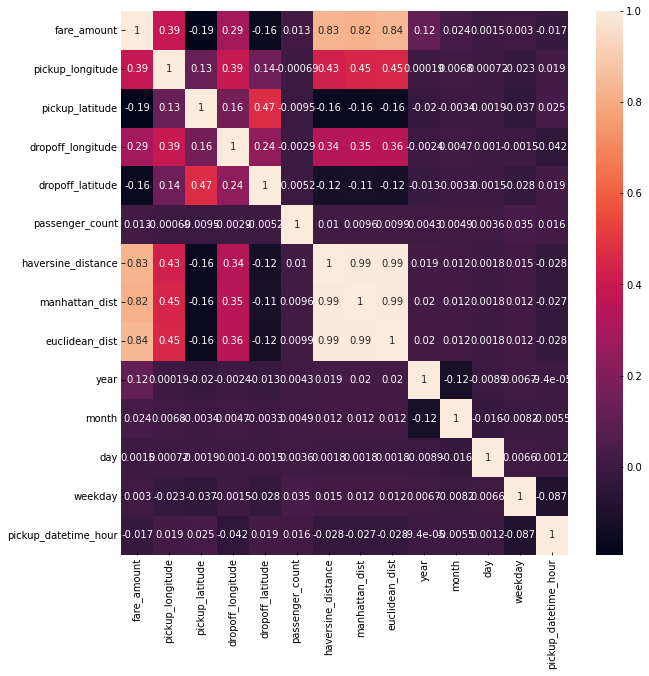

In [33]:
# Heatmap of the corelation matrix

plt.figure(figsize = (10, 10))
sns.heatmap(df.corr(), annot = True)

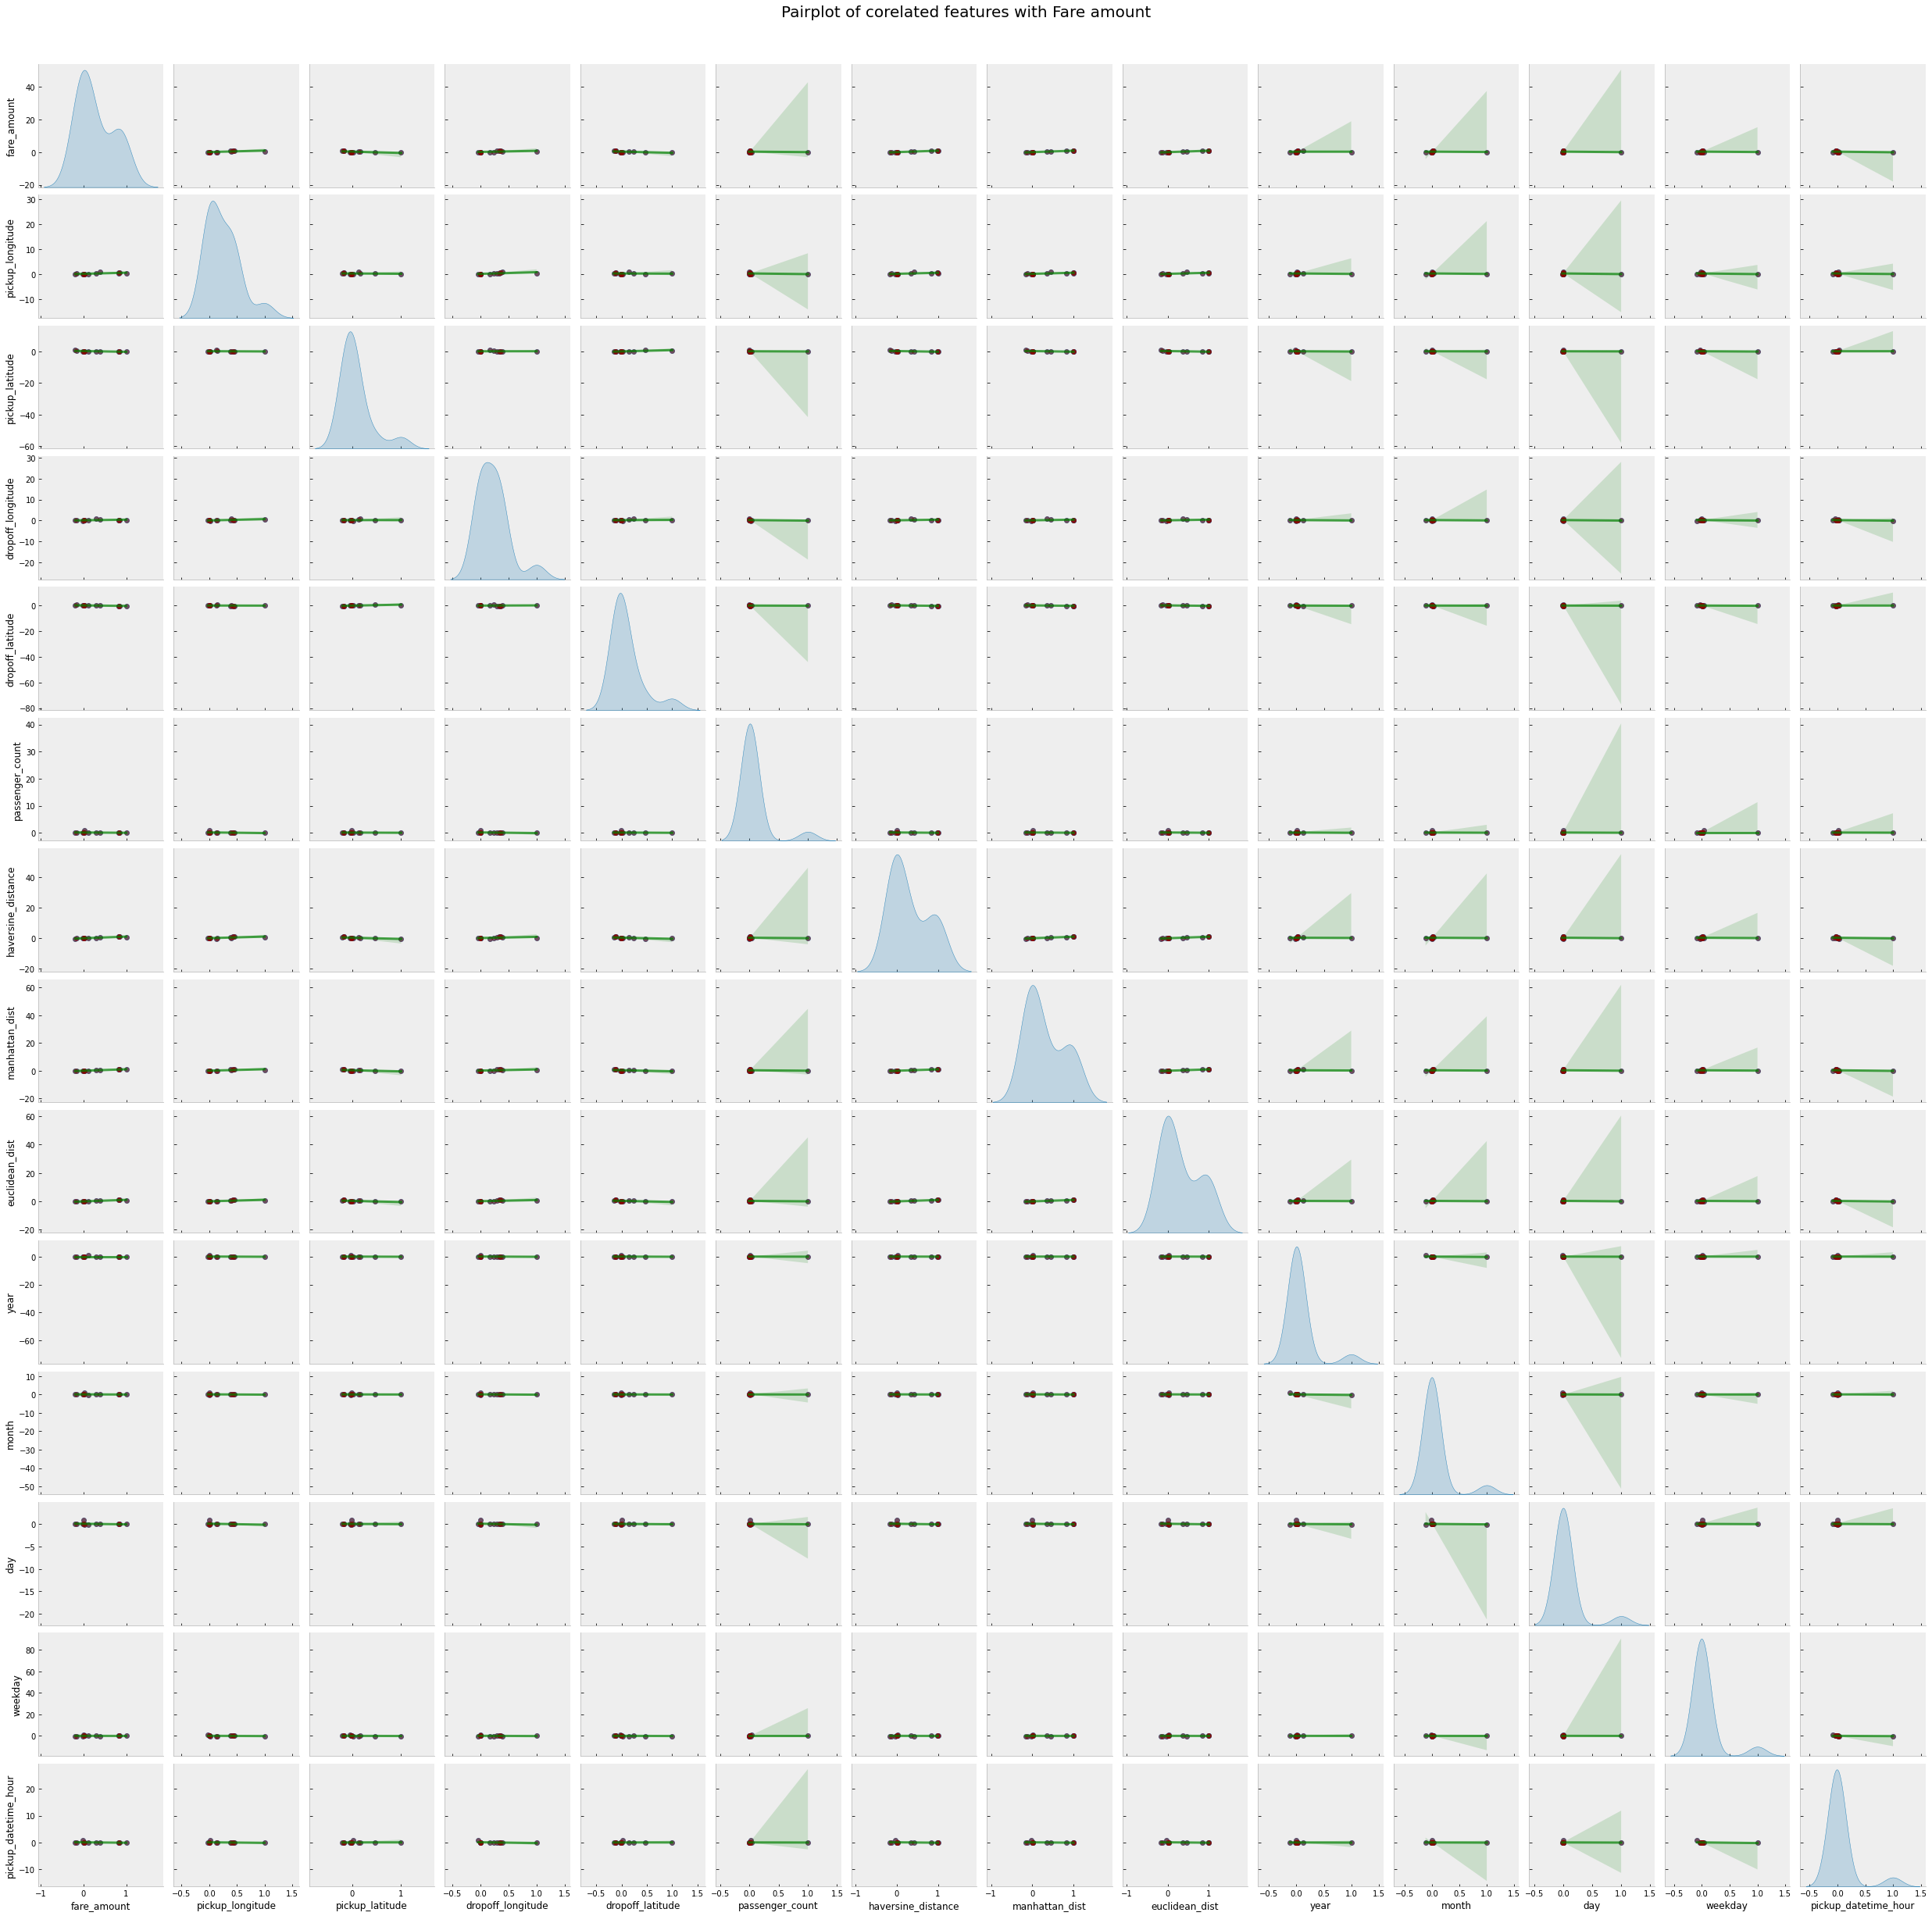

In [34]:
g = sns.pairplot(df_corr, kind = 'reg', diag_kind = 'kde', plot_kws = {'line_kws':{'color':'green', 'alpha': 0.7}})
# g = g.map_diag(sns.displot, color = 'darkred')
g = g.map_offdiag(plt.scatter, alpha = 0.5, color = 'darkred')
g.fig.suptitle('Pairplot of corelated features with Fare amount', fontsize = 20)
plt.subplots_adjust(top = 0.95)

In this section, we can observe that the corelation between the euclidean distance and taxi fare is the highest from the rest thus, we can delete the rest. 

## 3.2 Deep dive into parameters against fare_amount

In [35]:
# busiest day of the week?
df.weekday.mode()

0    4
dtype: int64

In [36]:
# busiest time of the day?
df.pickup_datetime_hour.mode()

0    19
dtype: int64

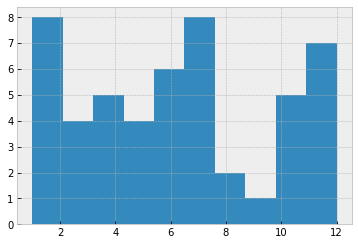

In [37]:
# In which month are fares the highest? >>> winters have high fare and Jan has highest fare
df_fare= df.sort_values(ascending=False, by= 'fare_amount').head(50)
df_fare.month.hist();

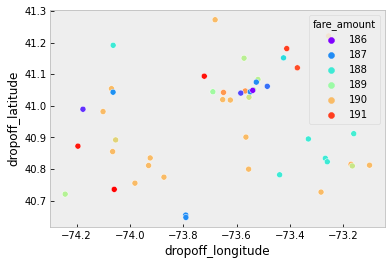

In [46]:
# Which drop locations have the highest fares?
sns.scatterplot(x='dropoff_longitude', y= 'dropoff_latitude',hue='fare_amount',data=df_fare, palette = 'rainbow');

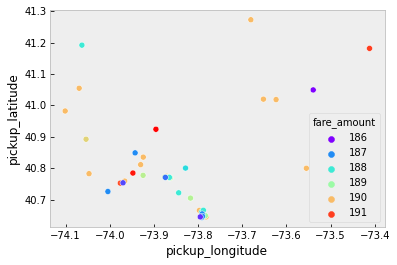

In [47]:
# Which pickup locations have the highest fares?
sns.scatterplot(x='pickup_longitude', y= 'pickup_latitude', hue='fare_amount',data=df_fare, palette = 'rainbow');

### Plot between Hour of day vs Number of Rides (during that time)

Observations:
* Morning time period observed least umber of rides 
* Evening slot has maximum number of rides.
* Throughout the working hours, the number of rides are on higher side.

In [ ]:
plt.figure(figsize=(15,7))
plt.hist(df.pickup_datetime_hour, bins=100)
plt.title('Hour vs Number of Rides')
plt.xlabel('Hour')
plt.ylabel('Frequency')

#### Drop the unnecessary features from the data to reduce the overall computation time.

In [38]:
df = df.drop(['pickup_datetime', 'haversine_distance', 'manhattan_dist', 'year', 'month', 'day'], axis = 1)

In [39]:
import gc
gc.collect()

3879

In [40]:
df_test

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1
...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51 UTC,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51 UTC,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15 UTC,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19 UTC,-73.985573,40.735432,-73.939178,40.801731,6


## 3.3 Add the required features to __Test data__ i.e. Euclidean distance weekday and hour of the day column

In [41]:
df_test['euclidean_dist'] = getEuclidean_distance(df_test.pickup_longitude, df_test.pickup_latitude,
                                       df_test.dropoff_longitude, df_test.dropoff_latitude).astype(np.float32)
df_test['pickup_datetime'] =  pd.to_datetime(df_test['pickup_datetime'].str.slice(0,19), utc=True, format='%Y-%m-%d %H:%M:%S')
add_dateparts(df_test, 'pickup_datetime')

df_test = df_test.drop(['key', 'pickup_datetime', 'year', 'month', 'day'], axis = 1)

# 4. Data visualization

### Scattered plot between Euclidean distance of the ride and the taxi fare

* For Distance vs Fare graph, some low euclidean distance records have relatively higher fare amount than for certain big distances. (although for distances less than 0.5, it seems strongly correlated with fare.)

* For Fare vs Distance graph, apart from where fare amount is near 0 and distances are unusual high (on top left portion), the other parts show strong correlation i.e. fare is increasing > distance is also increasing

Below are shown these two graphs.

In [42]:
'''Function to plot scatter plot'''
def scatter_plot(x, y, title, xaxis, yaxis, size, c_scale):
    trace = go.Scatter(
    x = x,
    y = y,
    mode = 'markers',
    marker = dict(color = y, size = size, showscale = True, colorscale = c_scale))
    layout = go.Layout(hovermode= 'closest', title = title, xaxis = dict(title = xaxis), yaxis = dict(title = yaxis))
    fig = go.Figure(data = [trace], layout = layout)
    return iplot(fig)    
    
'''Function to plot histogram'''
def plot_histogram(x, title, yaxis, color):
    trace = go.Histogram(x = x,
                        marker = dict(color = color))
    layout = go.Layout(hovermode= 'closest', title = title, yaxis = dict(title = yaxis))
    fig = go.Figure(data = [trace], layout = layout)
    return iplot(fig)

Text(0, 0.5, 'Fare')

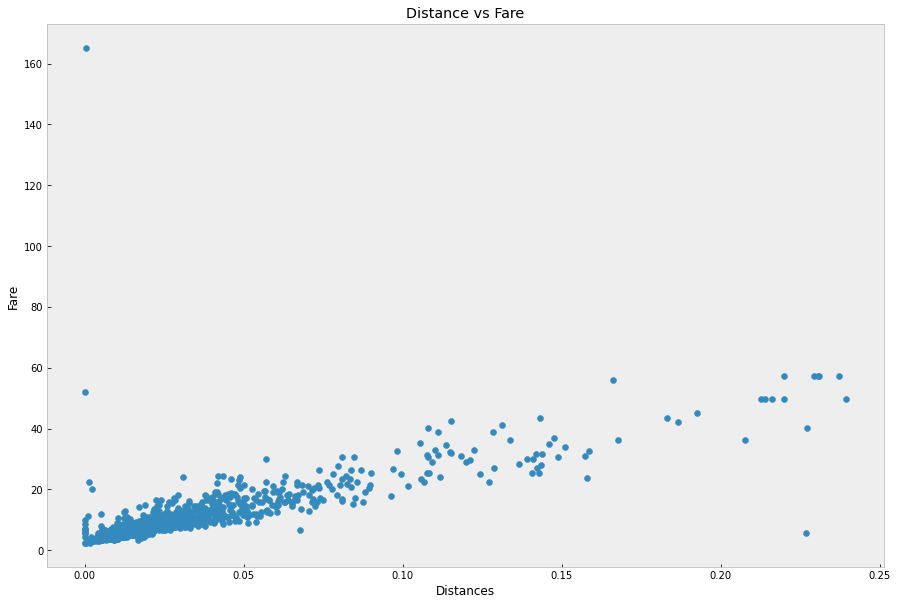

In [43]:
plt.figure(figsize=(15,10))
plt.scatter(df.euclidean_dist[0:10**3],df.fare_amount[0:10**3])
plt.title('Distance vs Fare')
plt.xlabel('Distances')
plt.ylabel('Fare')

#### Scattered plot between time of day and distance traveled

* The plot shows that distances traveled is uncorrelated with time of day. (distances traveled is similar across different time)

Text(0, 0.5, 'Distances')

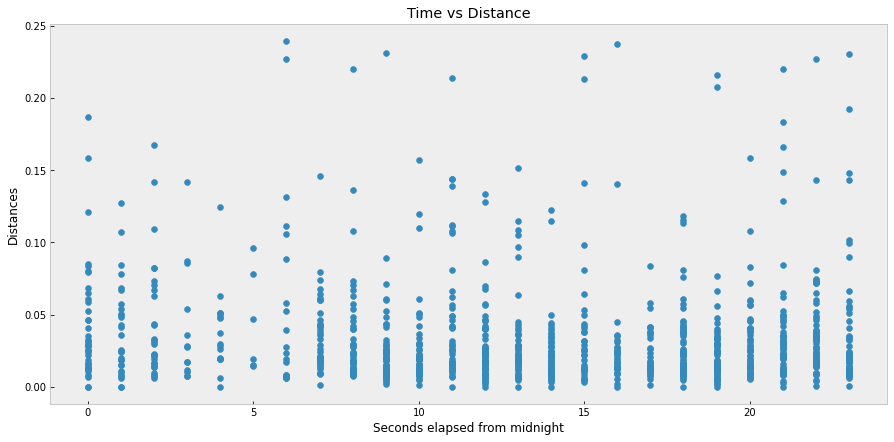

In [44]:
plt.figure(figsize=(15,7))
plt.scatter(df.pickup_datetime_hour[0:10**3],df.euclidean_dist[0:10**3])
plt.title('Time vs Distance')
plt.xlabel('Seconds elapsed from midnight')
plt.ylabel('Distances')

#### Scattered plot between time of day and the taxi fare

The plot shows that fare is uncorrelated with time of day. (fare paid is distributed similarly across time period)

Text(0, 0.5, 'Fare')

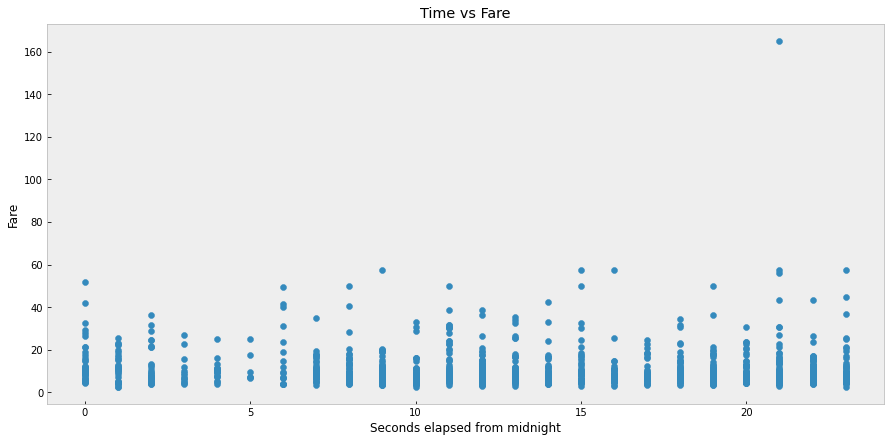

In [45]:
plt.figure(figsize=(15,7))
plt.scatter(df.pickup_datetime_hour[0:10**3],df.fare_amount[0:10**3])
plt.title('Time vs Fare')
plt.xlabel('Seconds elapsed from midnight')
plt.ylabel('Fare')

## 4.1 Heatmap of Pickup points on NYC map

Reference: https://alysivji.github.io/getting-started-with-folium.html

Observations:
* Most of pickup points are in Manhattan (more specifically in Lower Manhattan, Midtown, Upper East and Upper West side)
* Certain area in Brooklyn (Dumbo near Manhattan and Brooklyn Bridge and williamsburg) and Long Island City in Queens contribute to most of pickup points in those two boroughs.
* Airports (JFK, LGA both in Queens) have very high heatmap (infer people take taxi to city frequently)
* On zooming in, hotspots like Penn Station, Times Square, Port Authority, Grand Central, South Ferry, Columbus Circle have high pickup counts. (maybe due to commuters taking cabs from penn st, port authority, grand central, south ferry (staten island people :P) and office areas (columbus circle, times square area).

In [48]:
# Basic Imports
import pandas as pd
import numpy as np
import urllib.request
import json
from time import sleep

# Visualization and geo-data imports
import matplotlib.pyplot as plt
import folium
from folium import plugins
import fiona
from shapely.geometry import shape,mapping, Point, Polygon, MultiPolygon
import geopandas
from geopandas.tools import sjoin
import seaborn as sns

# Modelling and training
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.



In [49]:
# initialize map with first row from training data as coordinates
m = folium.Map([40.721317, -73.844315], zoom_start=11)

for index, row in df[0:1000].iterrows():
    folium.CircleMarker([row['pickup_latitude'], row['pickup_longitude']],
                        radius=0.00001,
                        fill_color="#3db7e4"
                       ).add_to(m)
    
# convert to (n, 2) nd-array format for heatmap
stationArr = df[0:2500][['pickup_latitude', 'pickup_longitude']].to_numpy()

# plot heatmap
m.add_child(plugins.HeatMap(stationArr, radius=15))
m

In [50]:
del stationArr
del m

### Heatmap of Dropoff points on NYC map

Reference: https://alysivji.github.io/getting-started-with-folium.html

Observations:
* Unlike pickup points which are mostly concentrated in / near manhattan, dropoff points are spread little farther from Manhattan.Still most of dropoff points are spread throughout in Manhattan. (This time, it includes Harlem, Uptown on western side and part of Bronx as well)
* Certain area in Brooklyn, this time spread upto Prospect Park (Dumbo near Manhattan and Brooklyn Bridge and williamsburg) and Long Island City plus Jamica in Queens contribute to most of pickup points in those two boroughs. (Jamaica maybe because people take cab to it and then airtrain)
* Again airports (JFK, LGA both in Queens) and Newark (EWR) in NJ have very high heatmap.

In [51]:
m = folium.Map([40.712276, -73.841614], zoom_start=11)

for index, row in df[0:1000].iterrows():
    folium.CircleMarker([row['dropoff_latitude'], row['dropoff_longitude']],
                        radius=0.00001,
                        fill_color="#3db7e4"
                       ).add_to(m)
    
# convert to (n, 2) nd-array format for heatmap
stationArr = df[0:2500][['dropoff_latitude', 'dropoff_longitude']].to_numpy()

# plot heatmap
m.add_child(plugins.HeatMap(stationArr, radius=15))
m

In [52]:
del stationArr
del m

# 5. Splitting the dataset into training, validation set before buidling the model

In [53]:
df.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'euclidean_dist', 'weekday', 'pickup_datetime_hour'],
      dtype='object')

In [54]:
df_input = df[['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'euclidean_dist', 'weekday']]
df_target = df[['fare_amount']]

In [55]:
X_train, X_val, y_train, y_val = train_test_split(df_input,df_target, test_size=0.01)

In [56]:
#  Final shape of the training and testing dataset

print("X_train Size ", X_train.shape)
print("Y training size ", y_train.shape)
print("X validation size ", X_val.shape)
print("Y validation size ", y_val.shape)

X_train Size  (16043690, 7)
Y training size  (16043690, 1)
X validation size  (162058, 7)
Y validation size  (162058, 1)


# 6. Training the models: 

Below listed regression models are considered for the given problem statement: 
* Linear
* Polynomial Regression
* Lasso 
* Ridge
* Gradient Boosting
* XGBoost
* Random Forest 

As per the paramteres/input features, what regression model is best to apply. ???

In [57]:
'''Set a seed for reproducibility'''
seed = 43

'''Initialize all the regression models object we are interested in.'''
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

## 6.1 Linear Regression

In [59]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


Linear regression model tries to optimise bias and weights of the paramters to improve the performance of model by minimizing the cost function. 

Add a loss function and optimize parameter to make the model that can predict the accurate value of Y. The loss function for the linear regression is called as RSS or Residual sum of squares**.

Techniques for regularization: 
1. Ridge regularization
2. Lasso regularization



In [60]:
# To store the score of all the models to compare
training_score = []

In [61]:
Model_LR = LinearRegression()

Model_LR.fit(X_train,y_train)
Prediction = Model_LR.predict(X_val)
rmse = np.sqrt(mean_squared_error(Prediction, y_val))

training_score.append(rmse)

print("Score of the training model", Model_LR.score(X_train,y_train))
print("Score of the testing model", Model_LR.score(X_val,y_val))

print("Root Mean square error for validation set: ", rmse)

Score of the training model 0.7066503482830325
Score of the testing model 0.6956773601790514
Root Mean square error for validation set:  5.206819885104881


## 6.2 Polynomial Regressor

In [62]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [63]:
transformer = PolynomialFeatures(degree=2, include_bias=False)
transformer.fit(X_train)

PolynomialFeatures(include_bias=False)

In [64]:
model_pr = LinearRegression().fit(X_train,y_train)
Prediction = model_pr.predict(X_val)
rmse = np.sqrt(mean_squared_error(Prediction, y_val))

training_score.append(rmse)

print("Score of the training model", model_pr.score(X_train,y_train))
print("Score of the testing model", model_pr.score(X_val,y_val))

print("Root Mean square error for validation set: ", rmse)

Score of the training model 0.7066503482830325
Score of the testing model 0.6956773601790514
Root Mean square error for validation set:  5.206819885104881


## 6.3 RIdge regressor

In [65]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso

model_ridge = Ridge(alpha = 10)
model_ridge.fit(X_train,y_train)
Prediction = model_ridge.predict(X_val)
rmse = np.sqrt(mean_squared_error(Prediction, y_val))

training_score.append(rmse)

print("Score of the training model", model_ridge.score(X_train,y_train))
print("Score of the testing model", model_ridge.score(X_val,y_val))

print("Root Mean square error for validation set: ", rmse)

Score of the training model 0.7066502192797757
Score of the testing model 0.695684261231039
Root Mean square error for validation set:  5.206760847863273


## 6.4 Lasso Regression

In [66]:
model_lasso = Lasso(alpha = 10)
model_lasso.fit(X_train,y_train)
Prediction = model_lasso.predict(X_val)
rmse = np.sqrt(mean_squared_error(Prediction, y_val))

training_score.append(rmse)

print("Score of the training model", model_lasso.score(X_train,y_train))
print("Score of the testing model", model_lasso.score(X_val,y_val))

print("Root Mean square error for validation set: ", rmse)

Score of the training model 0.0
Score of the testing model -1.8920858880555613e-05
Root Mean square error for validation set:  9.438642393746704


## 6.5 Gradient Boosting

In [67]:
%%time

model_gb = GradientBoostingRegressor(random_state = 43)

model_gb.fit(X_train,y_train.values.ravel())
Prediction = model_gb.predict(X_val)
rmse = np.sqrt(mean_squared_error(Prediction, y_val))

training_score.append(rmse)

print("Score of the training model", model_gb.score(X_train,y_train))
print("Score of the testing model", model_gb.score(X_val,y_val))

print("Root Mean square error for validation set: ", rmse)

Score of the training model 0.8026027593039003
Score of the testing model 0.8001352800150505
Root Mean square error for validation set:  4.219621468292448
CPU times: user 1h 14min 50s, sys: 39.6 s, total: 1h 15min 30s
Wall time: 1h 15min 34s


## 6.6 xgboost

In [68]:
%%time

from xgboost import XGBRegressor

model_xgb = XGBRegressor(random_state=42, n_jobs=-1)
model_xgb.fit(X_train,y_train)

Prediction = model_xgb.predict(X_val)
rmse = np.sqrt(mean_squared_error(Prediction, y_val))

training_score.append(rmse)

print("Score of the training model", model_xgb.score(X_train,y_train))
print("Score of the testing model", model_xgb.score(X_val,y_val))

print("Root Mean square error for validation set: ", rmse)

Score of the training model 0.8346265791149476
Score of the testing model 0.8293243898185647
Root Mean square error for validation set:  3.89934045591002
CPU times: user 11min 47s, sys: 24.3 s, total: 12min 12s
Wall time: 3min 58s


## 6.7 Random Forest

using sklearn random forest library to build model and predict on test data.

It takes lots of time to run on entire dataset but gives best accuracy (minimizes RMSE).

In [69]:
%%time

rf = RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=43, n_estimators=50)

rf.fit(X_train,y_train.values.ravel())
Prediction = rf.predict(X_val)

rmse = np.sqrt(mean_squared_error(Prediction, y_val))

training_score.append(rmse)


print("Score of the training model", rf.score(X_train,y_train))
print("Score of the testing model", rf.score(X_val,y_val))

print("Root Mean square error for validation set: ", rmse)

Score of the training model 0.8221013180672595
Score of the testing model 0.817694929842374
Root Mean square error for validation set:  4.029997688937074


### __Compare the score of the above models__

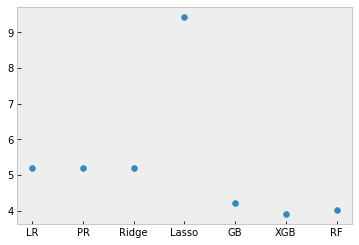

In [70]:
test_rmse = pd.DataFrame(data = training_score, columns=['RMSE'])
test_rmse.index = ['LR', 'PR', 'Ridge', 'Lasso', 'GB', 'XGB', 'RF']

test_rmse = test_rmse.round(4)

x = test_rmse.index 
y = test_rmse['RMSE']

plt.scatter(x,y)
plt.show()

### Lasso & Ridge model with Cross Validation

In [71]:
# For Lasso Model

from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas = [0.0001, 0.001,0.01,0.1,1,10,100,1000], random_state = 42).fit(X_train, y_train)

print("LassoCV training score: ", lasso_cv.score(X_train, y_train))
print("LassoCV testing score: ", lasso_cv.score(X_val, y_val))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



LassoCV training score:  0.7066499958376015
LassoCV testing score:  0.6956728327561085


In [72]:
# For Ridge Model

from sklearn.linear_model import RidgeCV

ridgecv = RidgeCV(alphas = [0.0001, 0.001,0.01,0.1,1,10,100]).fit(X_train, y_train)

print("RidgeCV training score: ", ridgecv.score(X_train, y_train))
print("RidgeCV testing score: ", ridgecv.score(X_val, y_val))

RidgeCV training score:  0.7066503469913618
RidgeCV testing score:  0.6956780627217664


# 7. Tune Hyperparmeters
We will use the Grid search method to hypertune the model.

In [ ]:
seed = 43

In [ ]:
'''Hyperparameters of gb'''
gb_opt = GradientBoostingRegressor(n_estimators = 3000, learning_rate = 0.05,
                                   max_depth = 4, max_features = 'sqrt',
                                   min_samples_leaf = 15, min_samples_split = 10, 
                                   loss = 'huber', random_state = seed)

In [ ]:
gb_opt.fit(X_train,y_train)

Prediction = gb_opt.predict(X_val)
rmse = np.sqrt(mean_squared_error(Prediction, y_val))

training_score.append(rmse)

print("Score of the training model", gb_opt.score(X_train,y_train))
print("Score of the testing model", gb_opt.score(X_val,y_val))

print("Root Mean square error for validation set: ", rmse)

In [ ]:
'''Hyperparameters of xgb'''
xgb_opt = XGBRegressor(colsample_bytree = 0.4603, gamma = 0.0468, 
                             learning_rate = 0.04, max_depth = 3, 
                             min_child_weight = 1.7817, n_estimators = 2500,
                             reg_alpha = 0.4640, reg_lambda = 0.8571,
                             subsample = 0.5213, silent = 1,
                             nthread = -1, random_state = 7)

In [ ]:
xgb_opt.fit(X_train,y_train)

Prediction = xgb_opt.predict(X_val)
rmse = np.sqrt(mean_squared_error(Prediction, y_val))

training_score.append(rmse)

print("Score of the training model", xgb_opt.score(X_train,y_train))
print("Score of the testing model", xgb_opt.score(X_val,y_val))

print("Root Mean square error for validation set: ", rmse)

In [ ]:
def grid_search_cv(model, params):
    global best_params, best_score
    from sklearn.model_selection import GridSearchCV
    grid_search = GridSearchCV(estimator = model, param_grid = params, cv = 10, verbose = 1,
                            scoring = 'neg_mean_squared_error', n_jobs = -1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_ 
    best_score = np.sqrt(-1*(np.round(grid_search.best_score_, 5)))
    return best_params, best_score

In [ ]:
# For lasso

''''Define hyperparameters of lasso.'''
alpha = [0.0001, 0.00025, 0.00031, 0.00035, 0.001, 0.005, 0.01]

lasso_params = {'alpha': alpha,
               'random_state':[seed]}

grid_search_cv(model_lasso, lasso_params)
lasso_best_params, lasso_best_score = best_params, best_score
print('Lasso best params:{} & best_score:{:0.5f}' .format(lasso_best_params, lasso_best_score))

In [ ]:
''''Define hyperparameters of ridge.'''
ridge_params = {'alpha':[ 9, 9.5, 9.6, 9.7, 9.8],
               'random_state':[seed]}

grid_search_cv(model_ridge, ridge_params)
ridge_best_params, ridge_best_score = best_params, best_score
print('Ridge best params:{} & best_score:{:0.5f}' .format(ridge_best_params, ridge_best_score))

In [ ]:
# max_depth=10, n_jobs=-1, random_state=43, n_estimators=50

'''Define hyperparameters of RF regressor'''

max_depth = [5,8,10,15,20]
n_estimators = [25,35,45,50,55,60]
rfg_params = {'max_depth': max_depth,
            'random_state' :43, 
            'n_estimators' :n_estimators}

grid_search_cv(rf, rfg_params)
rfg_best_params, rfg_best_score = best_params, best_score
print('Ridge best params:{} & best_score:{:0.5f}' .format(rfg_best_params, rfg_best_score))

# 8. Retrain the model with best optimized parameteres and store the test score and save the sumission file in csv

In [ ]:
lasso_opt = model_lasso(**lasso_best_params)
ridge_opt = model_ridge(**ridge_best_params)
xgb_opt = xgb_opt
gb_opt = gb_opt
rf_opt = rf(**rf_best_params)

In [ ]:
test_score_rmse = []
def predict_with_optimized_models(models):
    model.fit(X_train, y_train)
    y_pred = np.expm1(mode.predict(df_test))
    rmse = np.sqrt(mean_squared_error(Prediction, y_val))
    submission = pd.DataFrame()
    submission['Id']= test.Id
    submission['SalePrice'] = y_pred
    test_score_rmse.append(rmse)
    return submission

In [ ]:
'''Make submission with optimized lasso, ridge, kernel_ridge, elastic_net and svm, xgb, gb, and lgb.'''
predict_with_optimized_models(lasso_opt).to_csv('lasso_optimized.csv', index = False)
predict_with_optimized_models(ridge_opt).to_csv('ridge_optimized.csv', index = False)
predict_with_optimized_models(xgb_opt).to_csv('xgb_optimized.csv', index = False)
predict_with_optimized_models(gb_opt).to_csv('gb_optimized.csv', index = False)
predict_with_optimized_models(rf_opt).to_csv('lgb_optimized.csv', index = False)